# WorldCover land cover change

Using the 2020 and 2021 collections of ESA WorldCover, we will detect the land cover change over two areas

In order to browse the stac catalogue and load the images, the `pystac-client` and `rasterio` libraries are used.

To visualize and analyse the data, `numpy` and `matplotlib` are used.

## Search for related products in the STAC Catalogue

In [1]:
from pystac_client import Client

# URL to the Terrascope STAC API
TERRASCOPE_STAC_API = 'https://services.terrascope.be/stac/'

# Here is the collection ID of both 2020 and 2021 collection
COLLECTION_ID_2021 = 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'
COLLECTION_ID_2020 = 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1'

# WSG84 Coordinates of a dam in Egypt
BBOX = [30.1130394910927,23.24936336126656,30.918270526070845,23.612044886242117]

client = Client.open(TERRASCOPE_STAC_API)

search_results_2020 = client.search(
    max_items=10,
    collections=[COLLECTION_ID_2020],
    bbox=BBOX
)

search_results_2021 = client.search(
    max_items=10,
    collections=[COLLECTION_ID_2021],
    bbox=BBOX
)

# Search results fetched and represented as dictionnary
results_2020 = search_results_2020.get_all_items()
results_2021 = search_results_2021.get_all_items()

## Load the full products rasters in memory

Using `rasterio`, we will load the full raster data used to compute land cover change.

Subsampled versions will also be loaded to visualisation, as the full data is too large to be visualized using `matplotlib`.

In [2]:
# Open the image and load the data with rasterio.
import rasterio
import os

item_asset_2020 = results_2020[0].assets['ESA_WORLDCOVER_10M_MAP']
item_asset_2021 = results_2021[0].assets['ESA_WORLDCOVER_10M_MAP']

# The WorldCover products are available on a free AWS S3 bucket. 
# Settings this environment variable is required so that rasterio does not try to find AWS Tokens.
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

with rasterio.open(item_asset_2020.href, 'r') as src:
    # Create a reading window from our BBOX
    reading_window = rasterio.windows.from_bounds(*BBOX, transform=src.transform)
    
    # Read the raster data
    raster_data_2020 = src.read(1, window=reading_window)
    raster_data_2020_subsampled = src.read(1, window=reading_window, out_shape=(src.width // 8, src.height // 8))
    
with rasterio.open(item_asset_2021.href, 'r') as src:
    # Create a reading window from our BBOX
    reading_window = rasterio.windows.from_bounds(*BBOX, transform=src.transform)
    
    # Read the full raster data for statistics
    raster_data_2021 = src.read(1, window=reading_window)
    
    # Reads subsampled raster data for visualization
    raster_data_2021_subsampled = src.read(1, window=reading_window, out_shape=(src.width // 8, src.height // 8))

    
raster_data_2020.shape, raster_data_2021.shape

((4352, 9662), (4352, 9662))

## Visualization of the area of interest

Before plotting the land cover maps, we will define a class and a function to convert label images into colorized rgb images, respecting the colors labels as defined by WorldCover.

In [3]:
import enum
import numpy as np

class LabelsColors(enum.Enum):

    # 10,0,100,0,255,Trees covered area
    # 20,255,187,34,255,Shrub covered area
    # 30,255,255,76,255,Grassland
    # 40,240,150,255,255,Cropland
    # 50,250,0,0,255,Built-up
    # 60,180,180,180,255,Bare areas
    # 70,240,240,240,255,Snow and/or ice cover
    # 80,0,100,200,255,Permament water bodies
    # 90,0,150,160,255,Herbaceous wetland
    # 95,0,207,117,255,Mangroves
    # 100,250,230,160,255,Lichens and mosses

    NO_DATA = (0, 'nodata', 'Not sure', 'No Data', np.array([0, 0, 0]))
    TREE = (10, 'tree', 'tree', 'Trees covered area',
            np.array([0, 100, 0]) / 255)
    SHRUB = (20, 'shrub', 'shrub', 'Shrub cover area',
             np.array([255, 187, 34]) / 255)
    GRASS = (30, 'grass', 'grassland', 'Grassland',
             np.array([255, 255, 76]) / 255)
    CROP = (40, 'crop', 'crops', 'Cropland', np.array([240, 150, 255]) / 255)
    BUILT = (50, 'built', 'urban/built-up',
             'Built-up', np.array([250, 0, 0]) / 255)
    BARE = (60, 'bare', 'bare', 'Bare areas', np.array([180, 180, 180]) / 255)
    SNOW_AND_ICE = (70, 'snow', 'snow and ice', 'Snow and/or ice cover',
                    np.array([240, 240, 240]) / 255)
    WATER = (80, 'water', 'water', 'Permanent water',
             np.array([0, 100, 200]) / 255)
    WETLAND = (90, 'wetland', 'wetland (herbaceous)', 'Herbaceous wetland',
               np.array([0, 150, 160]) / 255)
    MANGROVES = (95, 'mangroves', None, 'Mangroves',
                 np.array([0, 207, 117]) / 255)
    LICHENS = (100, 'lichens_mosses', 'Lichen and moss', 'Lichen and moss',
               np.array([250, 230, 160]) / 255)

    def __init__(self, val1, val2, val3, val4, val5):
        self.id = val1
        self.class_name = val2
        self.iiasa_name = val3
        self.esa_class_name = val4
        self.color = val5


def label_to_rgb(lc_pred, colors_enum=None):

    colors_enum = LabelsColors if colors_enum is None else colors_enum

    colors = {lc.id: {'name': lc.class_name,
                      'color': lc.color}
              for lc in colors_enum}

    rgb_pred = np.zeros((lc_pred.shape[0],
                         lc_pred.shape[1],
                         3))

    for k, v in colors.items():
        for ch in range(3):
            im = rgb_pred[:, :, ch]
            im[lc_pred == k] = v['color'][ch]

    return rgb_pred


# Translation of WorldCover integer values to land cover type name
lc_types = {
    0: 'Not available',
    10: 'Tree cover',
    20: 'Shrubland', 
    30: 'Grassland', 
    40: 'Cropland',
    50: 'Built-up',
    60: 'Base/Sparse vegetation',
    70: 'Snow and ice',
    80: 'Permanent water bodies',
    90: 'Herbaceous wetland',
    95: 'Mangroves',
    100: 'Moss and Lichen'
}

In [4]:
import matplotlib.pyplot as plt

# Convert the label rasters into RGB images
rgb_2020 = label_to_rgb(raster_data_2020_subsampled)
rgb_2021 = label_to_rgb(raster_data_2021_subsampled)

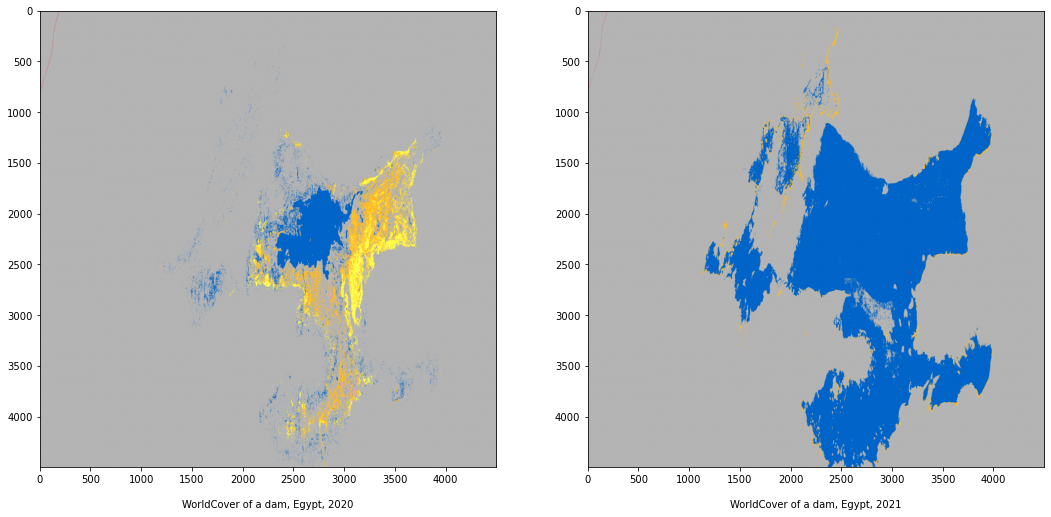

In [5]:
# Plots the subspampled rasters
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))
axis[0].imshow(rgb_2020)
axis[1].imshow(rgb_2021)
axis[0].set_xlabel('\nWorldCover of a dam, Egypt, 2020')
axis[1].set_xlabel('\nWorldCover of a dam, Egypt, 2021')

fig.show()

## Compute products statistics

Land cover statistics will be computed over the two region.

/tmp/ipykernel_10372/1665705113.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lc_labels)


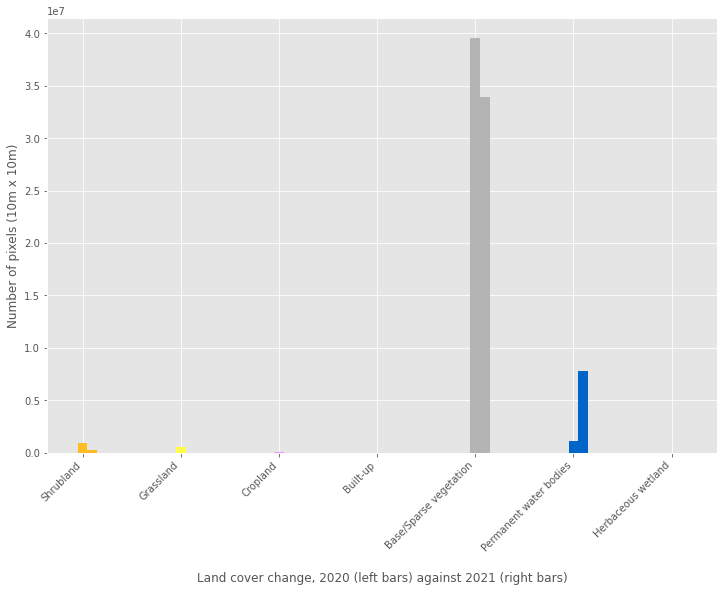

In [6]:
import numpy as np
from matplotlib import style

# Count the number of occurences (in pixels) for each class of the WorldCover product. 
values, occurences_2020 = np.unique(raster_data_2020, return_counts=True)
_, occurences_2021 = np.unique(raster_data_2021, return_counts=True)

# Get the label names from the label values in the raster
lc_labels = list(map(lambda val: lc_types[val], values))

# Get the colors for the charts
values_colors = label_to_rgb(values.reshape(-1, 1)).squeeze()

# Show a bar plot illustrating the representation of land cover classes in the area of interest
style.use('ggplot')

bar_width = 0.1
bar_size_2020 = np.arange(len(values[1:]))
bar_size_2021 = bar_size_2020 + bar_width

fix, ax = plt.subplots(figsize=(12, 8))
ax.bar(x=bar_size_2020, height=occurences_2020[1:], color=values_colors[1:], width=bar_width)
ax.bar(x=bar_size_2021, height=occurences_2021[1:], color=values_colors[1:], width=bar_width)
ax.set_xlabel('\nLand cover change, 2020 (left bars) against 2021 (right bars)')
ax.set_xticklabels(lc_labels)
ax.set_ylabel('Number of pixels (10m x 10m)')
plt.xticks(rotation=45, ha='right')
fig.show()

# Visualize the land-cover difference

We create a difference mask and visualize it.

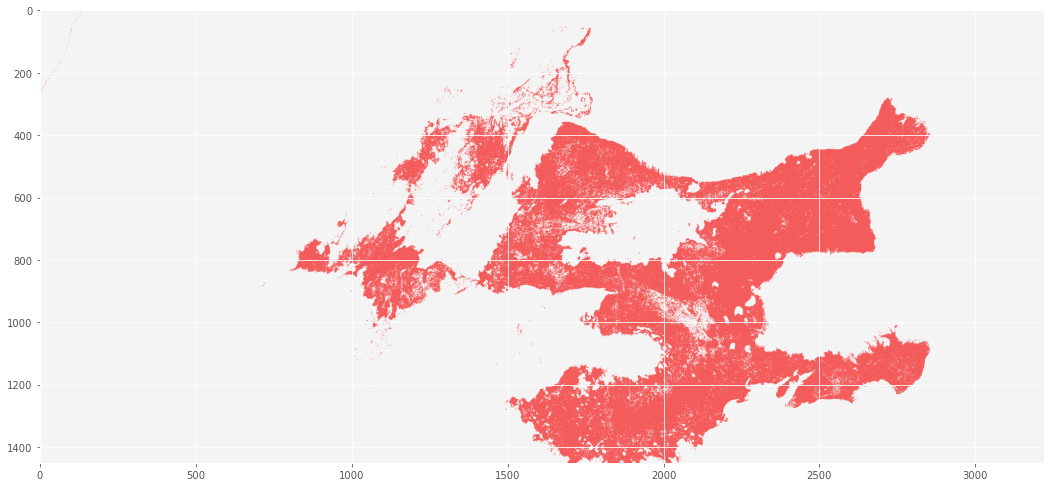

In [7]:
label_difference = raster_data_2020 != raster_data_2021
label_difference_subsampled = label_difference[::3, ::3]

label_difference_ss_rgb = np.zeros(shape=(*(label_difference_subsampled.shape), 3), dtype=np.uint8)

# Set to RED
label_difference_ss_rgb[label_difference_subsampled, 0] = 255
label_difference_ss_rgb[~label_difference_subsampled, :] = (255, 255, 255)


fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(label_difference_ss_rgb, alpha=0.6)
fig.show()

# Same operations for another environment

The same operations will be repeated for a small cropland scene in Missisipi, USA

In [8]:
# Free some valuable memory
raster_data_2020 = None
raster_data_2021 = None
rgb_2020 = None
rgb_2021 = None
label_difference = None
label_difference_subsampled = None
label_difference_subsampled_rgb = None

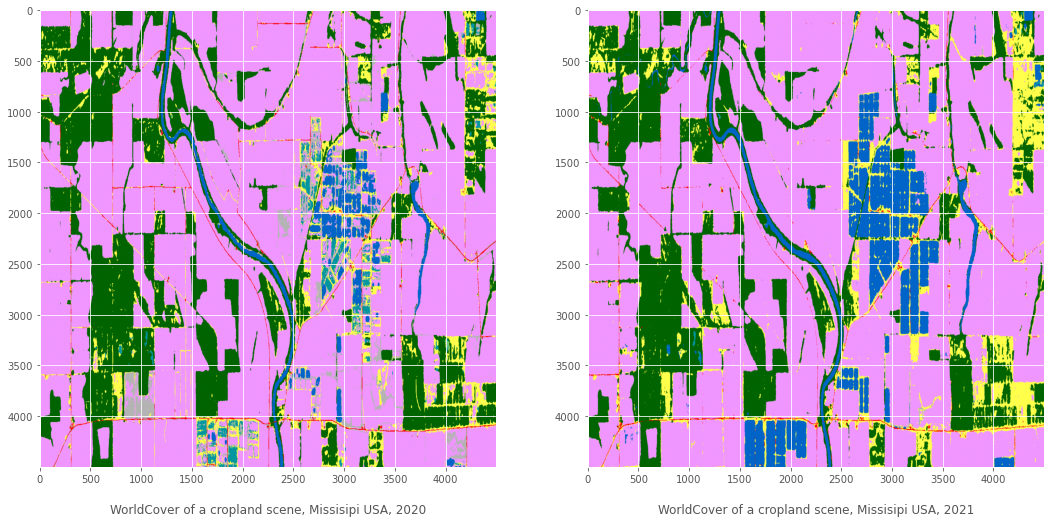

In [9]:
from pystac_client import Client

# WSG84 Coordinates of a dam in Egypt
BBOX = [-90.78373657266863,33.176930378602066,-90.59393529565605,33.248729067440536]

client = Client.open(TERRASCOPE_STAC_API)

search_results_2020 = client.search(
    max_items=10,
    collections=[COLLECTION_ID_2020],
    bbox=BBOX
)

search_results_2021 = client.search(
    max_items=10,
    collections=[COLLECTION_ID_2021],
    bbox=BBOX
)

# Search results fetched and represented as dictionnary
item_asset_2020 = search_results_2020.get_all_items()[0].assets['ESA_WORLDCOVER_10M_MAP']
item_asset_2021 = search_results_2021.get_all_items()[0].assets['ESA_WORLDCOVER_10M_MAP']

with rasterio.open(item_asset_2020.href, 'r') as src:
    # Create a reading window from our BBOX
    reading_window = rasterio.windows.from_bounds(*BBOX, transform=src.transform)
    
    # Read the raster data
    raster_data_2020 = src.read(1, window=reading_window)
    raster_data_2020_subsampled = src.read(1, window=reading_window, out_shape=(src.width // 8, src.height // 8))
    
with rasterio.open(item_asset_2021.href, 'r') as src:
    # Create a reading window from our BBOX
    reading_window = rasterio.windows.from_bounds(*BBOX, transform=src.transform)
    
    # Read the full raster data for statistics
    raster_data_2021 = src.read(1, window=reading_window)
    
    # Reads subsampled raster data for visualization
    raster_data_2021_subsampled = src.read(1, window=reading_window, out_shape=(src.width // 8, src.height // 8))


# Convert the label rasters into RGB images
rgb_2020 = label_to_rgb(raster_data_2020_subsampled)
rgb_2021 = label_to_rgb(raster_data_2021_subsampled)

# Plots the subspampled rasters
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))
axis[0].imshow(rgb_2020)
axis[1].imshow(rgb_2021)
axis[0].set_xlabel('\nWorldCover of a cropland scene, Missisipi USA, 2020')
axis[1].set_xlabel('\nWorldCover of a cropland scene, Missisipi USA, 2021')

fig.show()

/tmp/ipykernel_10372/343408371.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lc_labels)


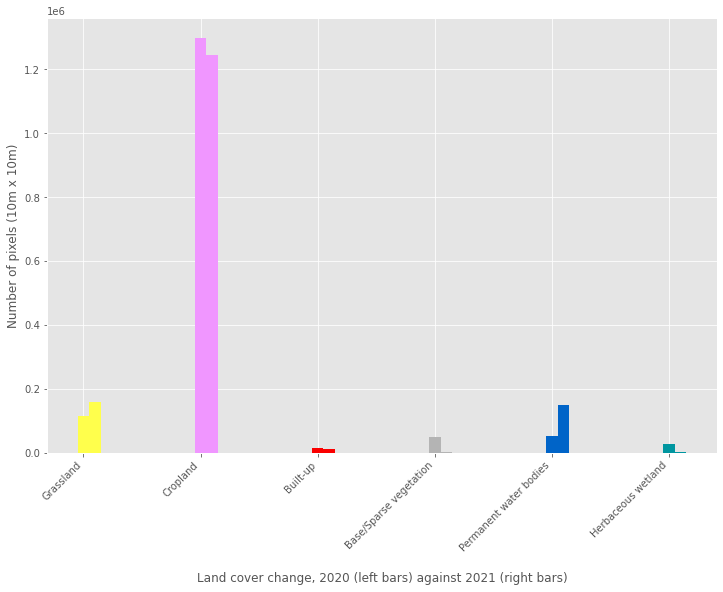

In [10]:
# Count the number of occurences (in pixels) for each class of the WorldCover product. 
values, occurences_2020 = np.unique(raster_data_2020, return_counts=True)
_, occurences_2021 = np.unique(raster_data_2021, return_counts=True)

# Get the label names from the label values in the raster
lc_labels = list(map(lambda val: lc_types[val], values))

# Get the colors for the charts
values_colors = label_to_rgb(values.reshape(-1, 1)).squeeze()

# Show a bar plot illustrating the representation of land cover classes in the area of interest
style.use('ggplot')

bar_width = 0.1
bar_size_2020 = np.arange(len(values[1:]))
bar_size_2021 = bar_size_2020 + bar_width

fix, ax = plt.subplots(figsize=(12, 8))
ax.bar(x=bar_size_2020, height=occurences_2020[1:], color=values_colors[1:], width=bar_width)
ax.bar(x=bar_size_2021, height=occurences_2021[1:], color=values_colors[1:], width=bar_width)
ax.set_xlabel('\nLand cover change, 2020 (left bars) against 2021 (right bars)')
ax.set_xticklabels(lc_labels)
ax.set_ylabel('Number of pixels (10m x 10m)')
plt.xticks(rotation=45, ha='right')
fig.show()

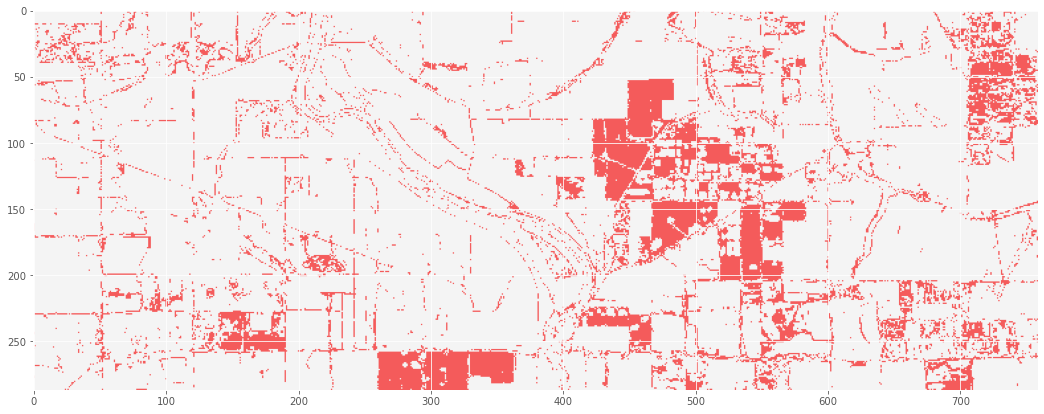

In [11]:
label_difference = raster_data_2020 != raster_data_2021
label_difference_subsampled = label_difference[::3, ::3]

label_difference_ss_rgb = np.zeros(shape=(*(label_difference_subsampled.shape), 3), dtype=np.uint8)

# Set to RED
label_difference_ss_rgb[label_difference_subsampled, 0] = 255
label_difference_ss_rgb[~label_difference_subsampled, :] = (255, 255, 255)


fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(label_difference_ss_rgb, alpha=0.6)
fig.show()